In [1]:
#setup libraries & data

#import pandas library for data analysis & manipulation
import pandas as pd
#import zipfile library to support reading zipped file into pandas dataframe
import zipfile
#import numpy library for scientific computing
import numpy as np
#import datetime library to work with time series data
import datetime as dt
#import seaborn & matplotlib libraries for visualization
import seaborn as sns
import matplotlib.pyplot as plt
#for publishing graphs inside jupyter notebooks
%matplotlib inline
#import statsmodel library for statisical models & analysis
import statsmodels.api as sm

#set file path names for data sources, Kaggle prediction competition provides seven sources 
#https://www.kaggle.com/competitions/store-sales-time-series-forecasting 

#training data for model
train_path = "C:\\Users\\mrmcq\\OneDrive\\Documents\\apu\\CapStone\\Project_Data\\train.csv.zip"
#daily volume of transactions per store
trans_path = "C:\\Users\\mrmcq\\OneDrive\\Documents\\apu\\CapStone\\Project_Data\\transactions.csv.zip"
#holiday schedule
holiday_path = "C:\\Users\\mrmcq\\OneDrive\\Documents\\apu\\CapStone\\Project_Data\\holidays.csv"
#daily oil prices
oil_path = "C:\\Users\\mrmcq\\OneDrive\\Documents\\apu\\CapStone\\Project_Data\\oil.csv"
#store location & type
stores_path = "C:\\Users\\mrmcq\\OneDrive\\Documents\\apu\\CapStone\\Project_Data\\stores.csv"
#test data for prediction model
test_path = "C:\\Users\\mrmcq\\OneDrive\\Documents\\apu\\CapStone\\Project_Data\\test.csv"
#sample format for submitting prediction to Kaggle
sample_path = "C:\\Users\\mrmcq\\OneDrive\\Documents\\apu\\CapStone\\Project_Data\\sample_submission.csv"

#import data into pandas dataframe
train_data = pd.read_csv(train_path,compression="zip")
trans_data = pd.read_csv(trans_path,compression="zip")
holiday_data = pd.read_csv(holiday_path)
oil_data = pd.read_csv(oil_path)
stores_data = pd.read_csv(stores_path)
test_data = pd.read_csv(test_path)
sample_data = pd.read_csv(sample_path)
                            
#check number of rows & columns in each set
print("training set",train_data.shape)
print("store transactions", trans_data.shape)
print("holiday calendar", holiday_data.shape)
print("daily oil prices", oil_data.shape)
print("store locations & types", stores_data.shape)
print("testing set", test_data.shape)
print("sample submission", sample_data.shape)


training set (3000888, 6)
store transactions (83488, 3)
holiday calendar (350, 6)
daily oil prices (1218, 2)
store locations & types (54, 5)
testing set (28512, 5)
sample submission (28512, 2)


In [2]:
#initially we looked at overall sales, now lets dig into the detail

In [3]:
#the first five rows of our training set
train_data.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:
#the pandas frame index matches the "id" column so the "id" can be dropped as extraneous
train_data = train_data.drop(['id'],axis=1)
train_data.head()

,date,store_nbr,family,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


In [5]:
#convert date from string object to data object, this will help with plotting & analysis
#conversion automatically adds time to date, removed as original data does not contain transaction times
#training data covers time range from January 1, 2013 to August 15, 2017
train_data["date"] = pd.to_datetime(train_data["date"],errors='coerce')
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   store_nbr    int64         
 2   family       object        
 3   sales        float64       
 4   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 114.5+ MB


In [6]:
#set format of output 
pd.options.display.float_format = "{:,.2f}".format

In [7]:
#let learn more about the stores
stores_data.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [8]:
#how are stores distributed?
stores_data.groupby(["state","city"]).store_nbr.count()

state                           city         
Azuay                           Cuenca            3
Bolivar                         Guaranda          1
Chimborazo                      Riobamba          1
Cotopaxi                        Latacunga         2
El Oro                          Machala           2
Esmeraldas                      Esmeraldas        1
Guayas                          Daule             1
                                Guayaquil         8
                                Libertad          1
                                Playas            1
Imbabura                        Ibarra            1
Loja                            Loja              1
Los Rios                        Babahoyo          1
                                Quevedo           1
Manabi                          El Carmen         1
                                Manta             2
Pastaza                         Puyo              1
Pichincha                       Cayambe           1
                  

In [9]:
#Quito is the largest city and capital of Ecuador 
#Guayquil is the second largest city and the nation's main port

In [10]:
#kaggle doesn't provide much information about what store types and store clusters mean
#so lets see what we can learn from the data
stores_data.groupby(["type","cluster"]).store_nbr.count()

type  cluster
A     5          1
      11         3
      14         4
      17         1
B     6          6
      10         1
      16         1
C     3          7
      7          2
      12         1
      15         5
D     1          3
      2          2
      4          3
      8          3
      9          2
      10         1
      13         4
E     10         4
Name: store_nbr, dtype: int64

In [11]:
#how are type and cluster related?
#lets start by seeing how many stores belong to each type/cluster grouping
store_types = pd.DataFrame(stores_data.groupby(["type","cluster"]).store_nbr.count())
store_types

store_nbr
type cluster           
A    5                1
     11               3
     14               4
     17               1
B    6                6
     10               1
     16               1
C    3                7
     7                2
     12               1
     15               5
D    1                3
     2                2
     4                3
     8                3
     9                2
     10               1
     13               4
E    10               4

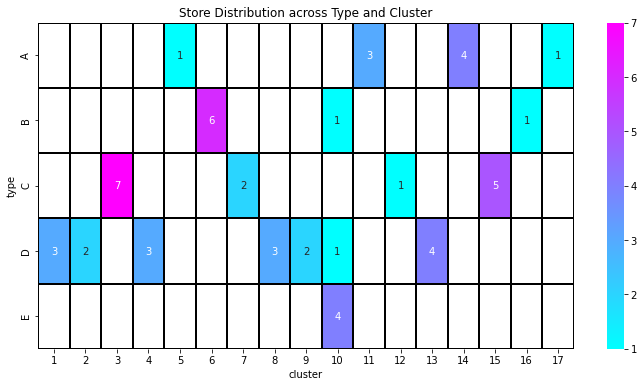

In [12]:
#lets look at the distribution graphically
plt.figure(figsize=(12,6))
plt.title("Store Distribution across Type and Cluster")
store_types_heatmap = store_types.pivot_table(values = "store_nbr",index = "type", columns="cluster",aggfunc=np.mean)
show = sns.heatmap(store_types_heatmap,cmap="cool", linewidths = 1, linecolor = "Black", annot=True)

In [13]:
#we can see type E is only associated with one cluster while type D is associated with 7 different clusters
#all clusters except 10 are associated with a single type
#type/cluster combinations C-3 and B-6 are associated with the most stores (7 & 6 respectively)
#clusters 5, 12, 16 & 17 are only associated with a single store
#at this stage we can't know if cluster 10 is an anolamy or not, or what any of these relationships mean

In [14]:
#lets check if they have anything to do with the regional information included in the data set
store_types = pd.DataFrame(stores_data.groupby(["state","type"]).store_nbr.count())
store_types

store_nbr
state                          type           
Azuay                          B             1
                               D             2
Bolivar                        C             1
Chimborazo                     C             1
Cotopaxi                       C             2
El Oro                         C             1
                               D             1
Esmeraldas                     E             1
Guayas                         A             1
                               B             1
                               C             3
                               D             3
                               E             3
Imbabura                       C             1
Loja                           D             1
Los Rios                       B             1
                               C             1
Manabi                         A             1
                               C             1
                               D             1
Pastaza                        C             1
Pichincha                      A             6
                               B             4
                               C             2
                               D             7
Santa Elena                    D             1
Santo Domingo de los Tsachilas B             1
                               C             1
                               D             1
Tungurahua                     A             1
                               D             1

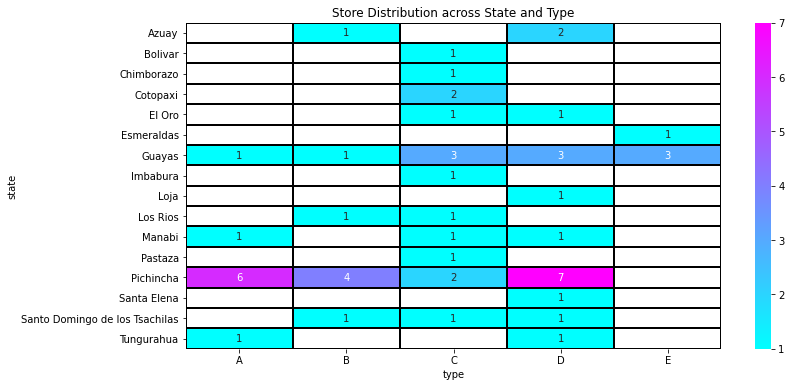

In [15]:
#is there a relationship between type/cluster and geography?
#lets try out a few charts
plt.figure(figsize=(12,6))
plt.title("Store Distribution across State and Type")
store_types_heatmap = store_types.pivot_table(values = "store_nbr",index = "state", columns="type",aggfunc=np.mean)
show = sns.heatmap(store_types_heatmap,cmap="cool", linewidths = 1, linecolor = "Black", annot=True)

In [16]:
store_types = pd.DataFrame(stores_data.groupby(["city","cluster"]).store_nbr.count())
store_types

store_nbr
city          cluster           
Ambato        9                1
              14               1
Babahoyo      10               1
Cayambe       6                1
Cuenca        2                2
              6                1
Daule         1                1
El Carmen     3                1
Esmeraldas    10               1
Guaranda      15               1
Guayaquil     1                1
              3                2
              6                1
              10               3
              17               1
Ibarra        15               1
Latacunga     15               2
Libertad      10               1
Loja          4                1
Machala       3                1
              4                1
Manta         11               1
              13               1
Playas        3                1
Puyo          7                1
Quevedo       3                1
Quito         5                1
              6                2
              8                3
              9                1
              11               2
              12               1
              13               3
              14               3
              15               1
              16               1
Riobamba      7                1
Salinas       1                1
Santo Domingo 3                1
              4                1
              6                1

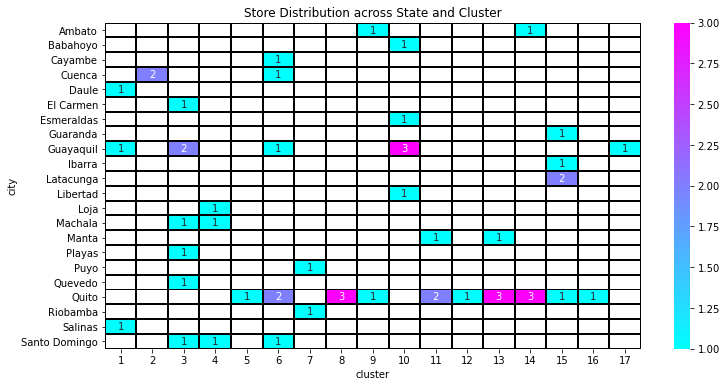

In [17]:
plt.figure(figsize=(12,6))
plt.title("Store Distribution across State and Cluster")
store_types_heatmap = store_types.pivot_table(values = "store_nbr",index = "city", columns="cluster",aggfunc=np.mean)
show = sns.heatmap(store_types_heatmap,cmap="cool", linewidths = 1, linecolor = "Black", annot=True)

In [18]:
#hmmmm, lets see if the transaction data will help us understand these relationships

In [19]:
trans_data.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [20]:
#sorting by store number so they appear in order on chart
trans_data.sort_values(by=["store_nbr"],inplace=True)
trans_data.head()

,date,store_nbr,transactions
42968,2015-07-03,1,2012
11033,2013-08-28,1,1831
81328,2017-07-07,1,1843
73300,2017-02-07,1,1887
2347,2013-02-22,1,1805


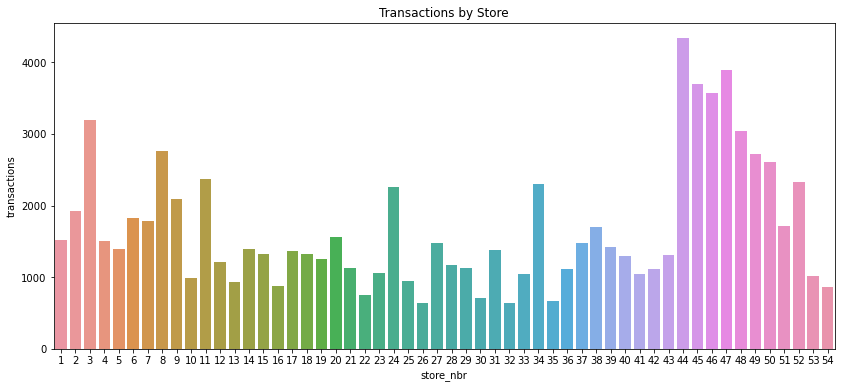

In [21]:
#taking a look at sales volume by store
plt.figure(figsize=(14,6))
plt.title("Transactions by Store")
ax = sns.barplot(x=trans_data["store_nbr"],y=trans_data["transactions"],ci=None)
plt.show()

In [22]:
trans_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83488 entries, 42968 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.6+ MB


In [23]:
trans_data["date"] = pd.to_datetime(trans_data["date"],errors='coerce')
trans_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83488 entries, 42968 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.6 MB


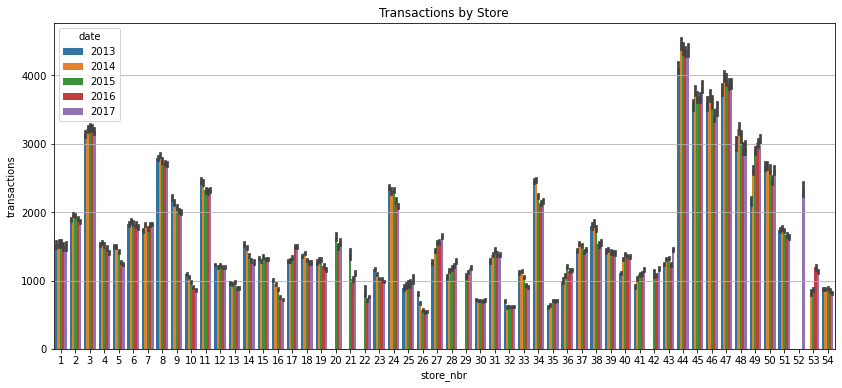

In [24]:
plt.figure(figsize=(14,6))
plt.title("Transactions by Store")
plt.grid()
ax = sns.barplot(x=trans_data["store_nbr"],y=trans_data["transactions"],hue=trans_data["date"].dt.year)

In [25]:
#stores vary in how busy they are...also some don't have any transactions in earlier years, likely new stores
#we can check when stores had their first sales
#store 52 looks like a success, relatively high salles in its first year

In [26]:
trans_data.groupby("store_nbr").date.min()

store_nbr
1    2013-01-02
2    2013-01-02
3    2013-01-02
4    2013-01-02
5    2013-01-02
6    2013-01-02
7    2013-01-02
8    2013-01-02
9    2013-01-02
10   2013-01-02
11   2013-01-02
12   2013-01-02
13   2013-01-02
14   2013-01-02
15   2013-01-02
16   2013-01-02
17   2013-01-02
18   2013-01-02
19   2013-01-02
20   2015-02-13
21   2015-07-24
22   2015-10-09
23   2013-01-02
24   2013-01-02
25   2013-01-01
26   2013-01-02
27   2013-01-02
28   2013-01-02
29   2015-03-20
30   2013-01-02
31   2013-01-02
32   2013-01-02
33   2013-01-02
34   2013-01-02
35   2013-01-02
36   2013-05-09
37   2013-01-02
38   2013-01-02
39   2013-01-02
40   2013-01-02
41   2013-01-02
42   2015-08-21
43   2013-01-02
44   2013-01-02
45   2013-01-02
46   2013-01-02
47   2013-01-02
48   2013-01-02
49   2013-01-02
50   2013-01-02
51   2013-01-02
52   2017-04-20
53   2014-05-29
54   2013-01-02
Name: date, dtype: datetime64[ns]

In [27]:
#lets check the last sale date also
trans_data.groupby("store_nbr").date.max()

store_nbr
1    2017-08-15
2    2017-08-15
3    2017-08-15
4    2017-08-15
5    2017-08-15
6    2017-08-15
7    2017-08-15
8    2017-08-15
9    2017-08-15
10   2017-08-15
11   2017-08-15
12   2017-08-15
13   2017-08-15
14   2017-08-15
15   2017-08-15
16   2017-08-15
17   2017-08-15
18   2017-08-15
19   2017-08-15
20   2017-08-15
21   2017-08-15
22   2017-08-15
23   2017-08-15
24   2017-08-15
25   2017-08-15
26   2017-08-15
27   2017-08-15
28   2017-08-15
29   2017-08-15
30   2017-08-15
31   2017-08-15
32   2017-08-15
33   2017-08-15
34   2017-08-15
35   2017-08-15
36   2017-08-15
37   2017-08-15
38   2017-08-15
39   2017-08-15
40   2017-08-15
41   2017-08-15
42   2017-08-15
43   2017-08-15
44   2017-08-15
45   2017-08-15
46   2017-08-15
47   2017-08-15
48   2017-08-15
49   2017-08-15
50   2017-08-15
51   2017-08-15
52   2017-08-15
53   2017-08-15
54   2017-08-15
Name: date, dtype: datetime64[ns]

In [28]:
#ok, at least for the date range of the data set, all stores remained active

In [29]:
#lets join the store & transaction data sets to see what more we can learn
store_trans = pd.concat([stores_data, trans_data], axis=1, join="outer")
store_trans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83488 entries, 0 to 83487
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   store_nbr     54 non-null     float64       
 1   city          54 non-null     object        
 2   state         54 non-null     object        
 3   type          54 non-null     object        
 4   cluster       54 non-null     float64       
 5   date          83488 non-null  datetime64[ns]
 6   store_nbr     83488 non-null  int64         
 7   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 5.7+ MB


In [30]:
store_trans.head()

,store_nbr,city,state,type,cluster,date,store_nbr,transactions
0,1.00,Quito,Pichincha,D,13.00,2013-01-01,25,770
1,2.00,Quito,Pichincha,D,13.00,2013-01-02,1,2111
2,3.00,Quito,Pichincha,D,8.00,2013-01-02,2,2358
3,4.00,Quito,Pichincha,D,9.00,2013-01-02,3,3487
4,5.00,Santo Domingo,Santo Domingo de los Tsachilas,D,4.00,2013-01-02,4,1922


In [31]:
store_trans.groupby("type").date.min()

type
A   2013-01-02
B   2013-01-02
C   2013-01-02
D   2013-01-01
E   2013-01-02
Name: date, dtype: datetime64[ns]

In [32]:
store_trans.groupby("cluster").date.min()

cluster
1.00    2013-01-02
2.00    2013-01-02
3.00    2013-01-02
4.00    2013-01-02
5.00    2013-01-02
6.00    2013-01-02
7.00    2013-01-02
8.00    2013-01-02
9.00    2013-01-02
10.00   2013-01-02
11.00   2013-01-02
12.00   2013-01-02
13.00   2013-01-01
14.00   2013-01-02
15.00   2013-01-02
16.00   2013-01-02
17.00   2013-01-03
Name: date, dtype: datetime64[ns]

In [33]:
#ok, so the age of a store has no relationship to the type or cluster
#how about sales volume?

In [34]:
store_trans.groupby("type").transactions.mean()

type
A   2,065.44
B   2,300.62
C   1,932.33
D   1,933.33
E   1,688.00
Name: transactions, dtype: float64

In [35]:
store_trans.groupby("type").transactions.median()

type
A   1,985.00
B   1,783.50
C   1,622.00
D   1,834.50
E   1,289.50
Name: transactions, dtype: float64

In [36]:
store_trans.groupby("cluster").transactions.median()

cluster
1.00    1,008.00
2.00    2,538.00
3.00    1,587.00
4.00    1,922.00
5.00    2,346.00
6.00    1,684.00
7.00    1,853.50
8.00    2,143.00
9.00    2,262.50
10.00   1,289.50
11.00   2,033.00
12.00   1,167.00
13.00   1,849.00
14.00   1,909.00
15.00   2,002.00
16.00   1,580.00
17.00   1,551.00
Name: transactions, dtype: float64

In [37]:
#no patterns here, lets look at the distribution of transactions

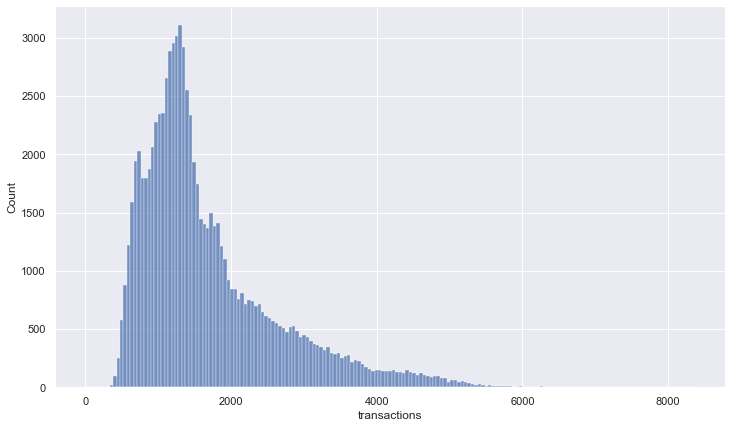

In [38]:
sns.set_theme()
f, ax = plt.subplots(figsize=(12, 7))
sns.despine(f)
ax = sns.histplot(store_trans, x = "transactions")

In [39]:
#distribution is clearly right skewed
#lets normalize it with a log transformation

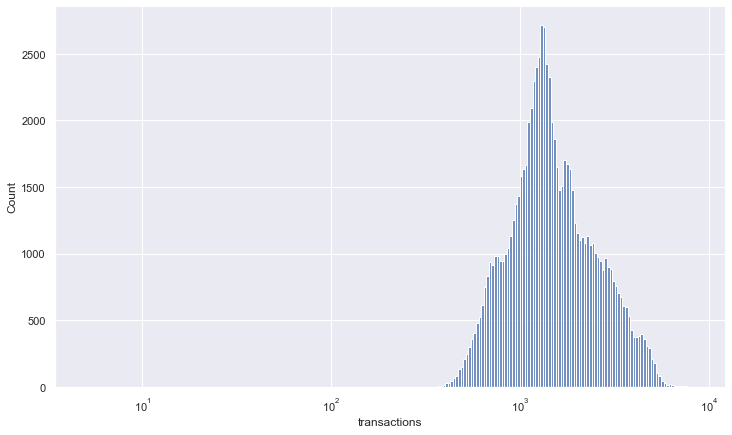

In [40]:

f, ax = plt.subplots(figsize=(12, 7))
sns.despine(f)
ax = sns.histplot(store_trans, x = "transactions",log_scale=True)

In [41]:
#time to dive into the training data!

In [42]:
store_trans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83488 entries, 0 to 83487
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   store_nbr     54 non-null     float64       
 1   city          54 non-null     object        
 2   state         54 non-null     object        
 3   type          54 non-null     object        
 4   cluster       54 non-null     float64       
 5   date          83488 non-null  datetime64[ns]
 6   store_nbr     83488 non-null  int64         
 7   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 5.7+ MB


In [43]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   store_nbr    int64         
 2   family       object        
 3   sales        float64       
 4   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 114.5+ MB


In [44]:
count_family = train_data.nunique()
count_family

date             1684
store_nbr          54
family             33
sales          379610
onpromotion       362
dtype: int64

In [45]:
#33 different families of product sold

In [46]:
#lets look at the median sales by family (means are susceptible to outliers)
family_sales = pd.DataFrame(train_data.groupby(["family"]).sales.median())
family_sales

,sales
family,
AUTOMOTIVE,5.00
BABY CARE,0.00
BEAUTY,2.00
BEVERAGES,"1,784.00"
BOOKS,0.00
BREAD/BAKERY,401.00
CELEBRATION,3.00
CLEANING,938.00
DAIRY,520.00


In [47]:
#sort to see top families
family_sales = family_sales.sort_values(by = "sales", ascending = False)
family_sales

,sales
family,
GROCERY I,"3,185.00"
BEVERAGES,"1,784.00"
CLEANING,938.00
DAIRY,520.00
BREAD/BAKERY,401.00
PRODUCE,398.29
MEATS,224.94
PERSONAL CARE,222.00
DELI,218.97


In [48]:
#review overall sales volume
family_vol = pd.DataFrame(train_data.groupby(["family"]).sales.sum().sort_values(ascending=False))
family_vol

,sales
family,
GROCERY I,"343,462,734.89"
BEVERAGES,"216,954,486.00"
PRODUCE,"122,704,684.68"
CLEANING,"97,521,289.00"
DAIRY,"64,487,709.00"
BREAD/BAKERY,"42,133,945.58"
POULTRY,"31,876,004.47"
MEATS,"31,086,468.40"
PERSONAL CARE,"24,592,051.00"


In [49]:
#all families have sales but show considerable spread in sales activitypy
#describe to see quick stats

In [50]:
family_vol.describe()

,sales
count,33.00
mean,"32,534,695.52"
std,"71,725,644.60"
min,"6,438.00"
25%,"548,842.00"
50%,"1,962,767.00"
75%,"24,592,051.00"
max,"343,462,734.89"


In [51]:
#big numbers at the top!  lets make them more understandable by calculating % of sales
family_vol["sales%"] = family_vol["sales"]/family_vol["sales"].sum()
family_vol

,sales,sales%
family,,
GROCERY I,"343,462,734.89",0.32
BEVERAGES,"216,954,486.00",0.20
PRODUCE,"122,704,684.68",0.11
CLEANING,"97,521,289.00",0.09
DAIRY,"64,487,709.00",0.06
BREAD/BAKERY,"42,133,945.58",0.04
POULTRY,"31,876,004.47",0.03
MEATS,"31,086,468.40",0.03
PERSONAL CARE,"24,592,051.00",0.02


In [ ]:
#tempting to make the dreaded pie chart at this point...but we'll keep going

In [52]:
#back to training data
train_data.head()

,date,store_nbr,family,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.00,0
1,2013-01-01,1,BABY CARE,0.00,0
2,2013-01-01,1,BEAUTY,0.00,0
3,2013-01-01,1,BEVERAGES,0.00,0
4,2013-01-01,1,BOOKS,0.00,0


In [53]:
#lets get a sense of how family sales trend by month
train_data["month"] = train_data["date"].dt.month
train_data.head()

,date,store_nbr,family,sales,onpromotion,month
0,2013-01-01,1,AUTOMOTIVE,0.00,0,1
1,2013-01-01,1,BABY CARE,0.00,0,1
2,2013-01-01,1,BEAUTY,0.00,0,1
3,2013-01-01,1,BEVERAGES,0.00,0,1
4,2013-01-01,1,BOOKS,0.00,0,1


In [54]:
family_month = pd.DataFrame(train_data.groupby(["family","month"]).sales.sum())
family_month

sales
family     month           
AUTOMOTIVE 1      47,404.00
           2      48,098.00
           3      54,156.00
           4      49,758.00
           5      50,095.00
...                     ...
SEAFOOD    8     156,857.13
           9     148,753.53
           10    150,285.74
           11    140,082.77
           12    129,417.17

[396 rows x 1 columns]

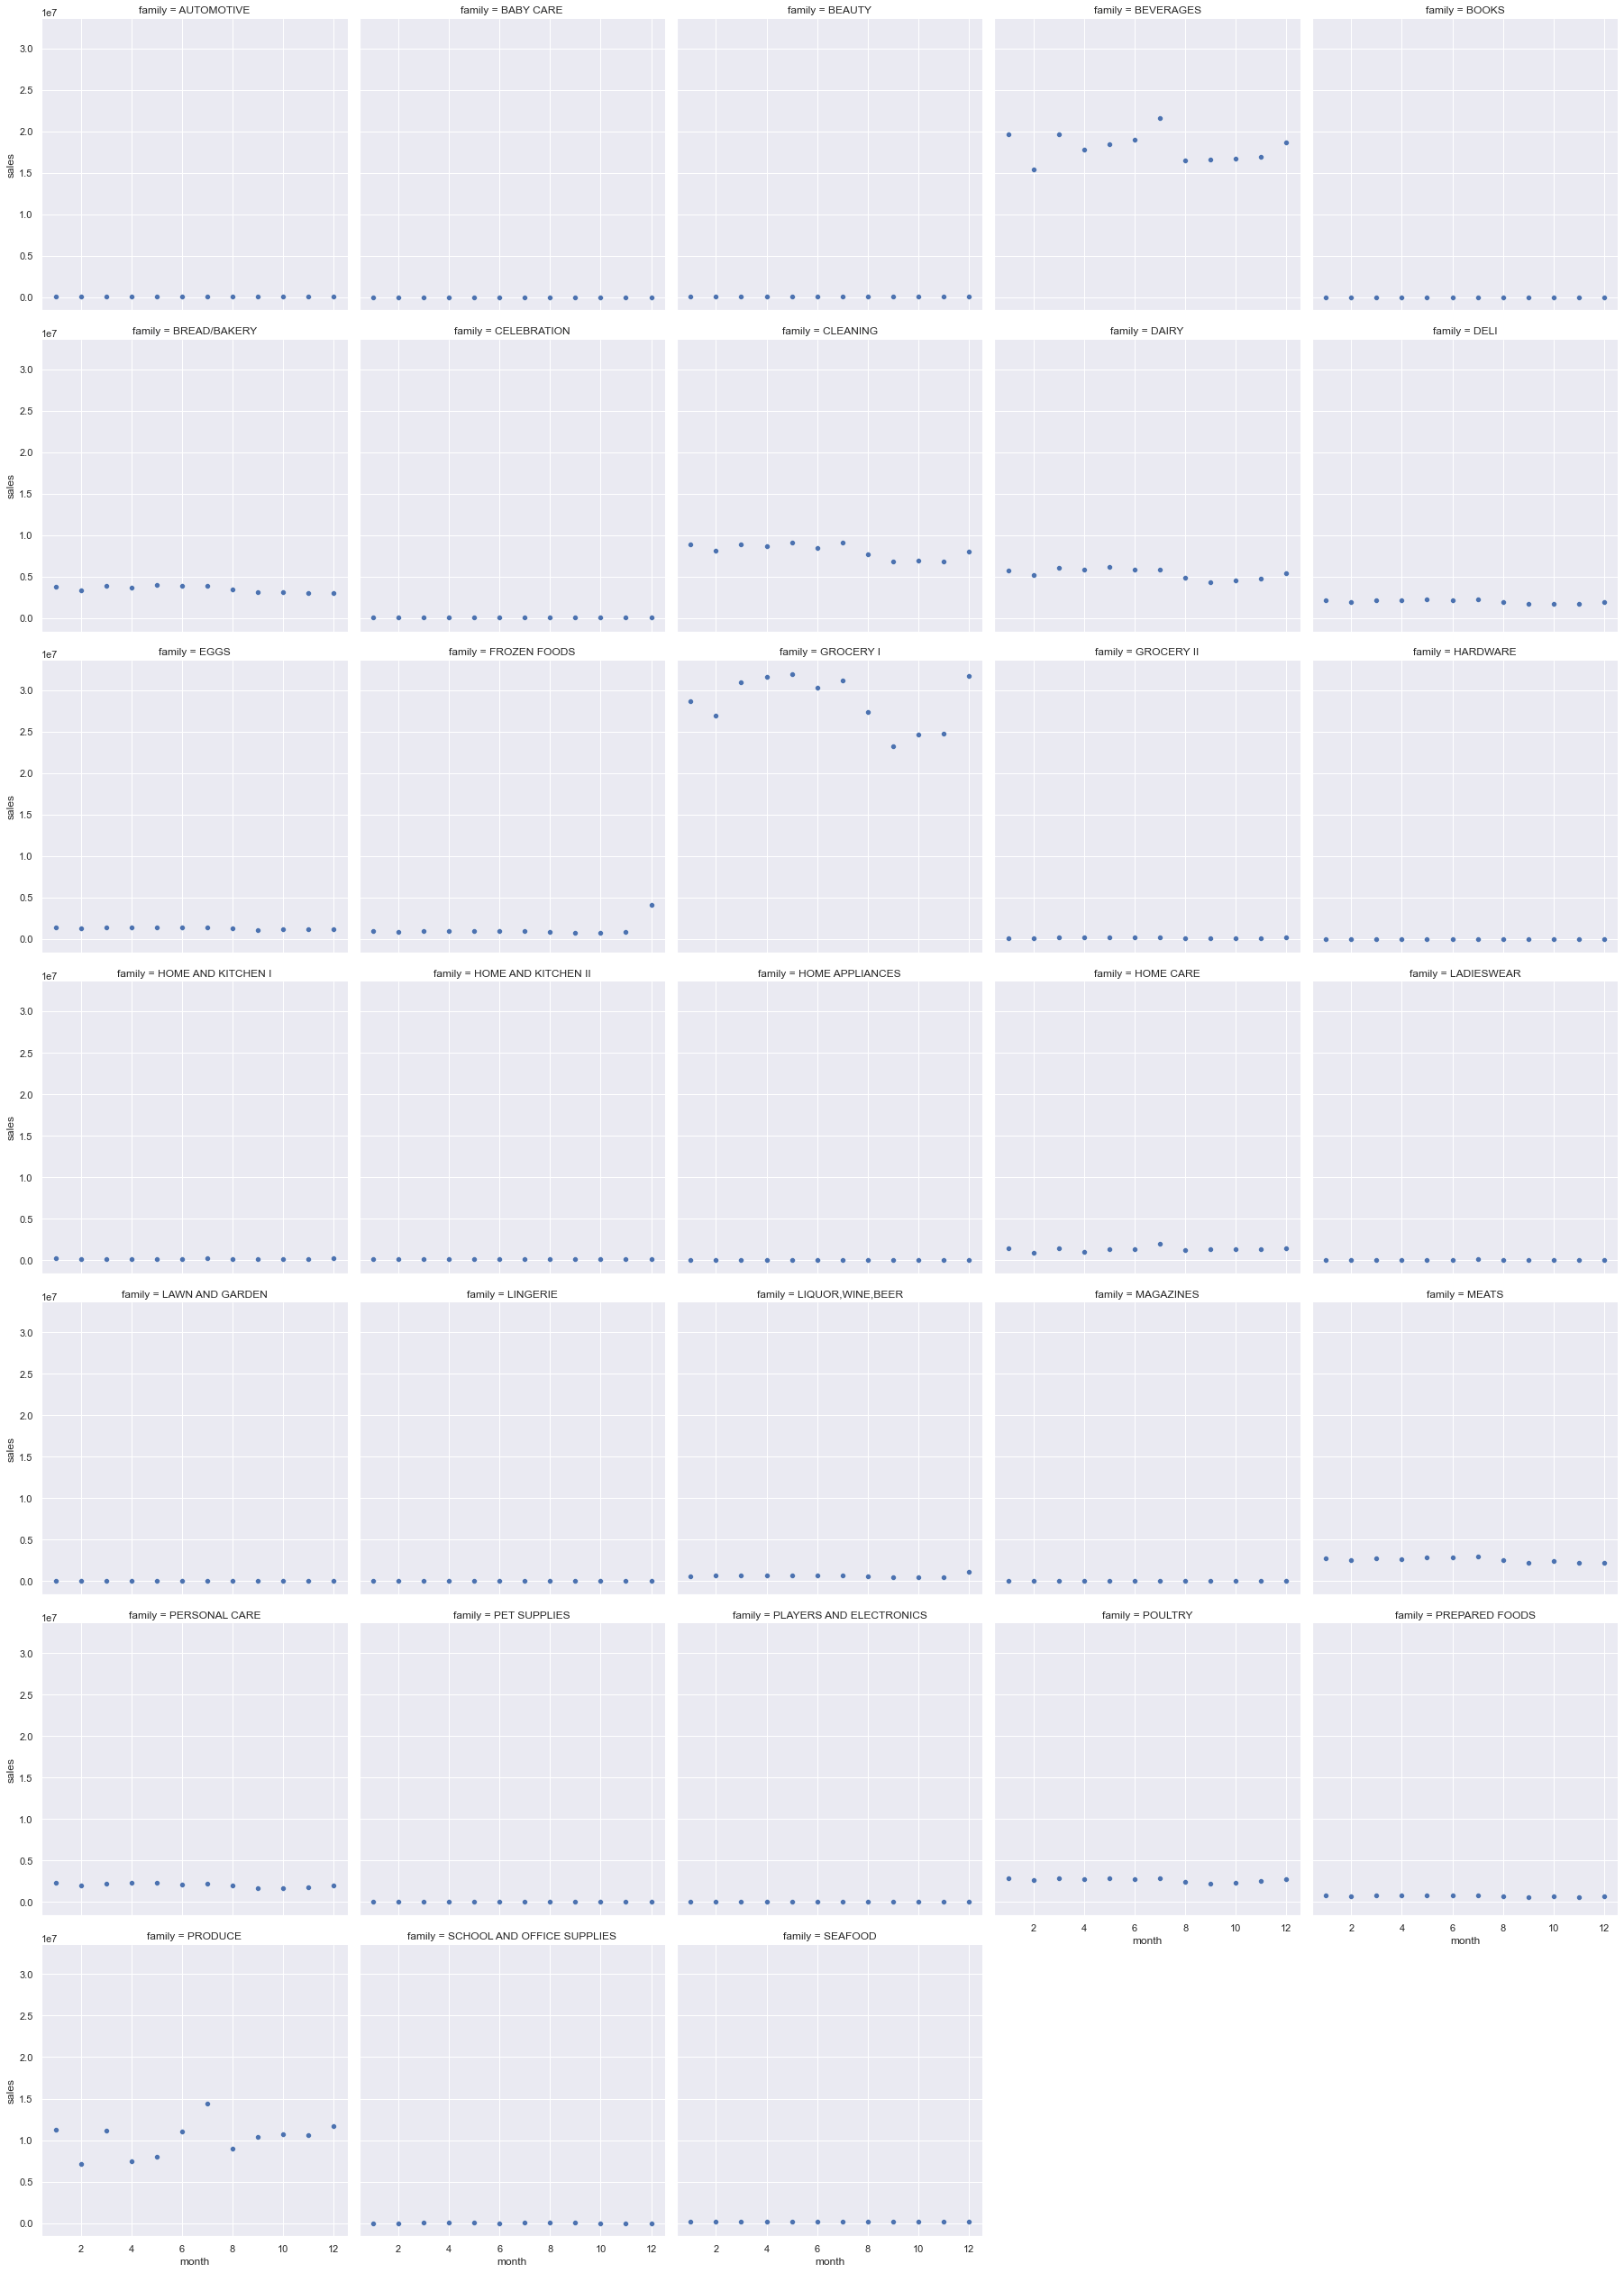

In [55]:
sns.relplot(data = family_month, x = "month", y = "sales", col = "family",col_wrap=5)

In [56]:
#the relative scales make it hard to see trends for lower volume families
#lets try log normalization
family_month["sales_log"] = np.log(family_month["sales"])

C:\Users\mrmcq\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [57]:
family_month.head()

sales  sales_log
family     month                     
AUTOMOTIVE 1     47,404.00      10.77
           2     48,098.00      10.78
           3     54,156.00      10.90
           4     49,758.00      10.81
           5     50,095.00      10.82

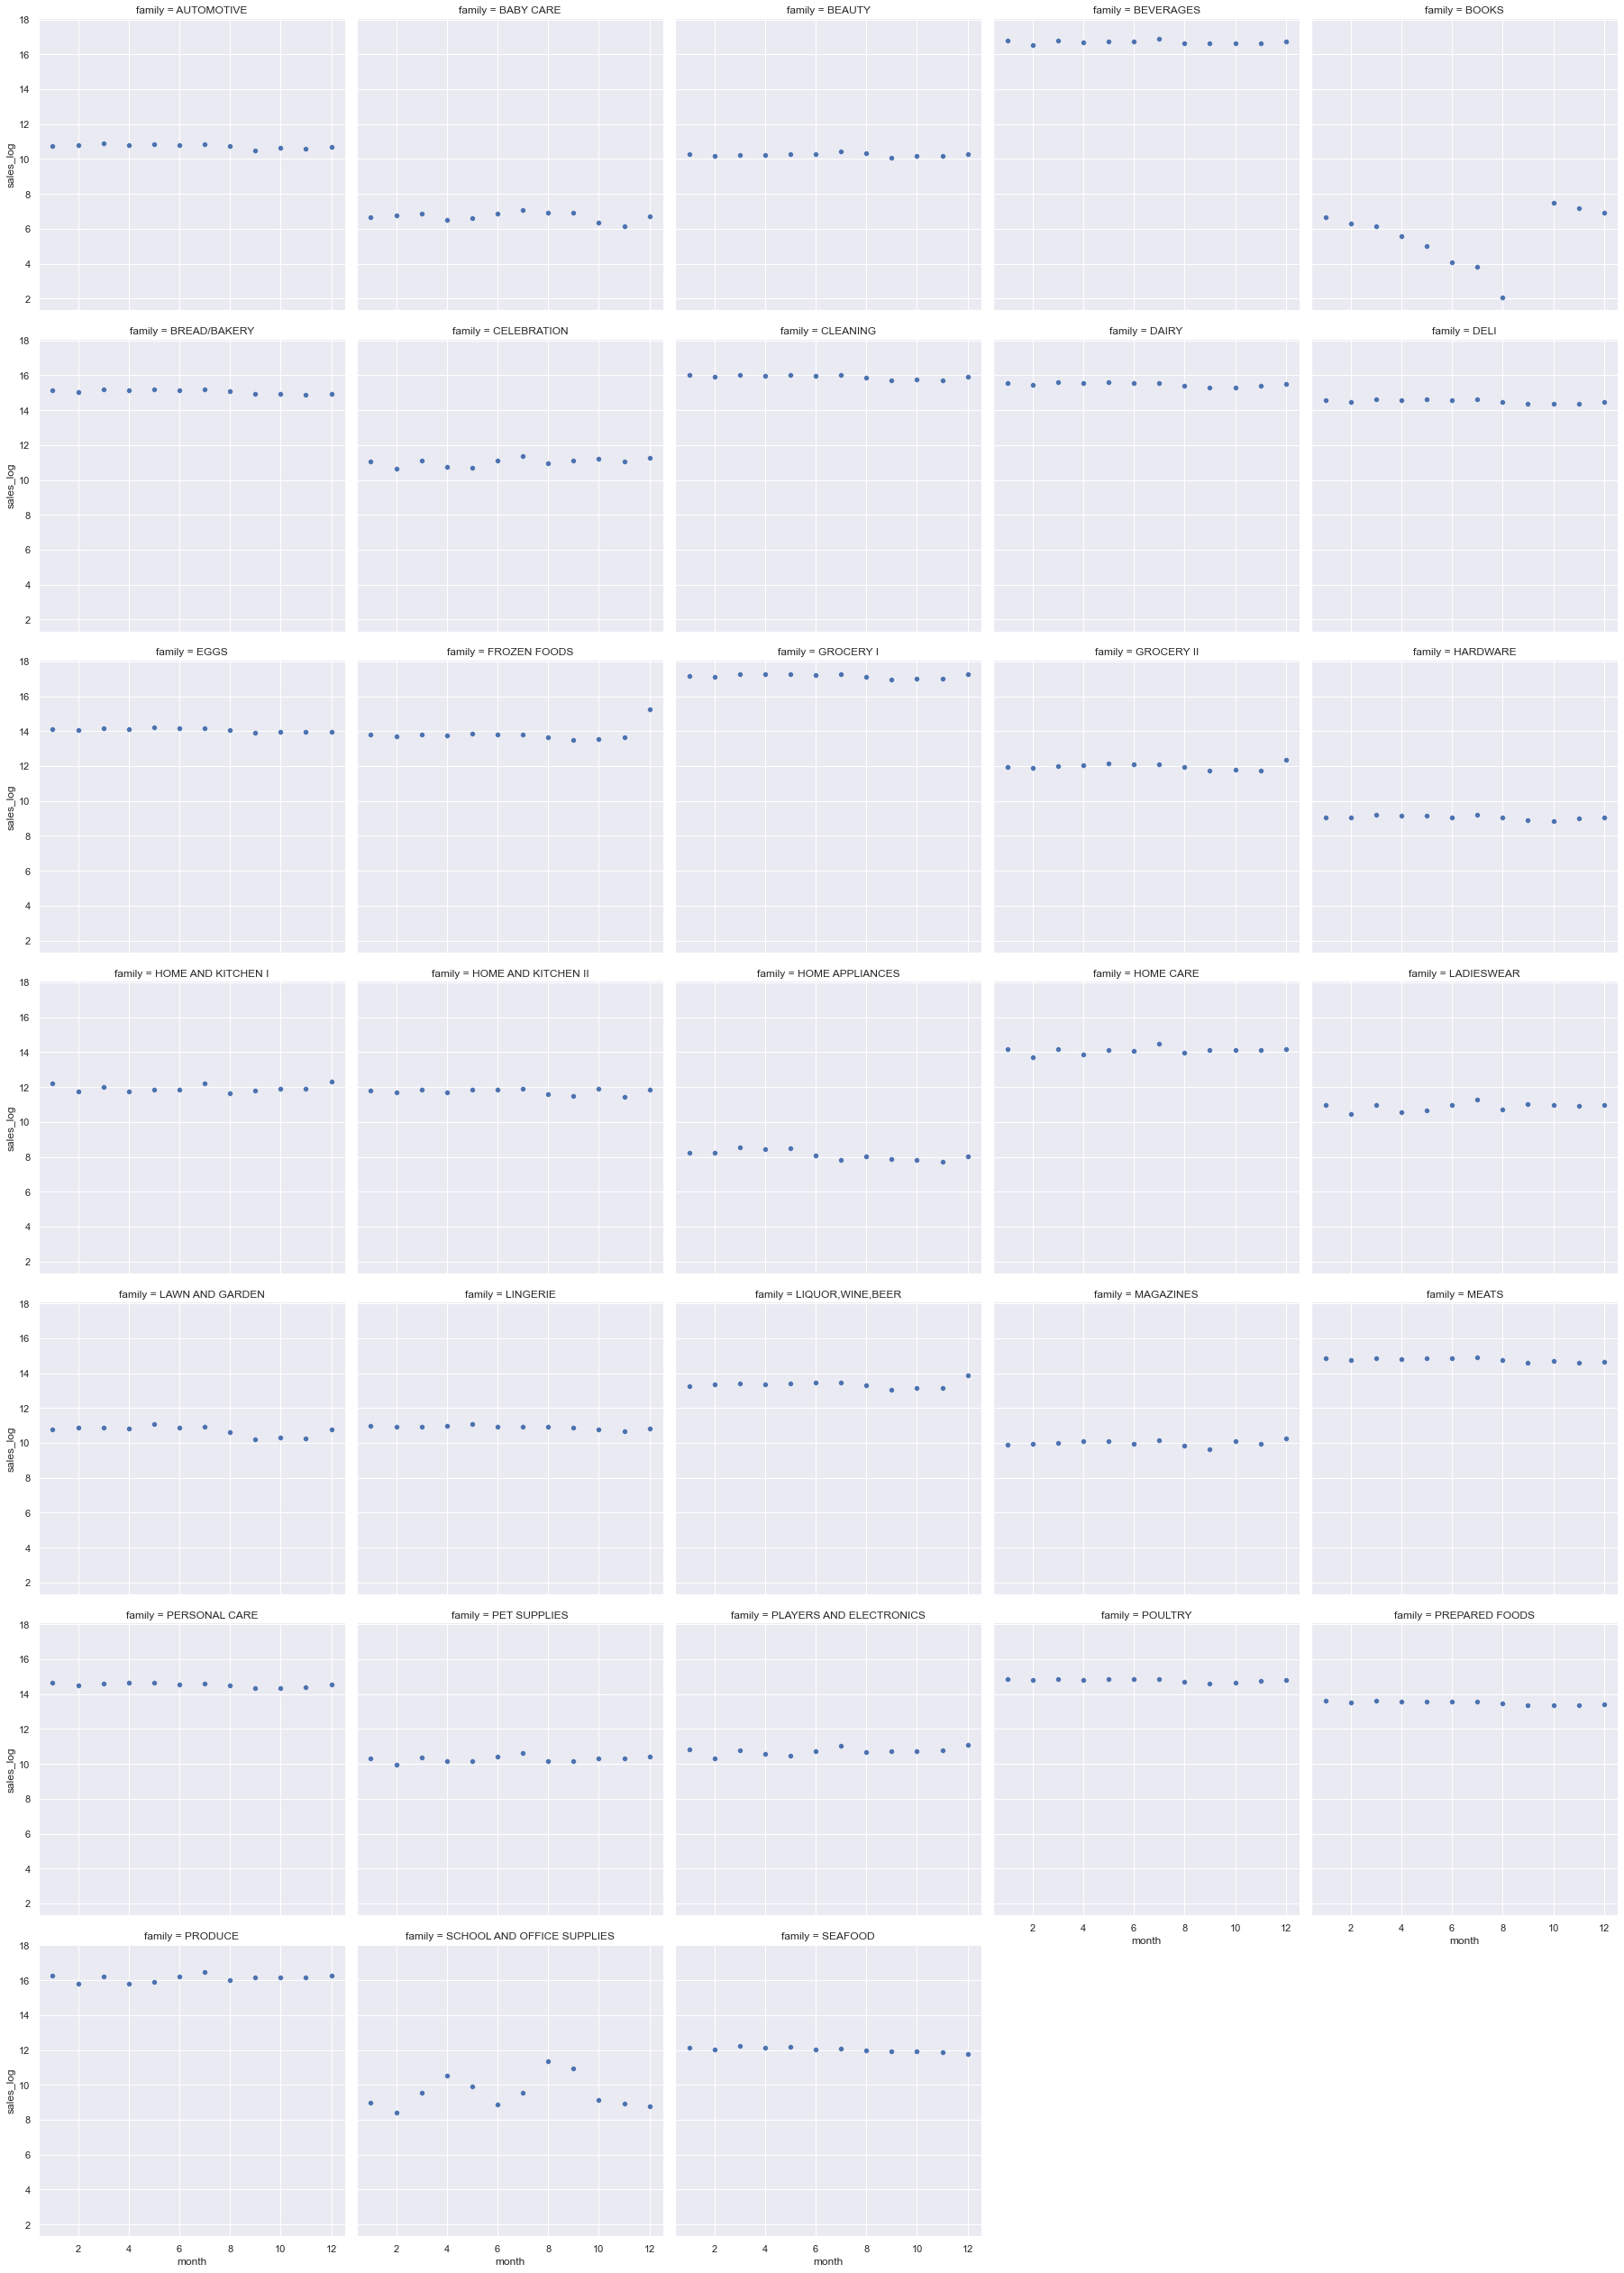

In [58]:
ax = sns.relplot(data = family_month, x = "month", y = "sales_log", col = "family",col_wrap=5,)

In [59]:
#no big surprises in seasonality but interesting
#book & school/office supplies show strong seasonality
#one more try to understand what value to store types/clusters provide...

In [60]:
stores_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [61]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   store_nbr    int64         
 2   family       object        
 3   sales        float64       
 4   onpromotion  int64         
 5   month        int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [62]:
train_data = train_data.drop(["month"],axis=1)

In [63]:
train_stores = pd.merge(stores_data, train_data, on="store_nbr", how="outer")
train_stores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000888 entries, 0 to 3000887
Data columns (total 9 columns):
 #   Column       Dtype         
---  ------       -----         
 0   store_nbr    int64         
 1   city         object        
 2   state        object        
 3   type         object        
 4   cluster      int64         
 5   date         datetime64[ns]
 6   family       object        
 7   sales        float64       
 8   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 228.9+ MB


In [64]:
train_stores.tail()

,store_nbr,city,state,type,cluster,date,family,sales,onpromotion
3000883,54,El Carmen,Manabi,C,3,2017-08-15,POULTRY,59.62,0
3000884,54,El Carmen,Manabi,C,3,2017-08-15,PREPARED FOODS,94.00,0
3000885,54,El Carmen,Manabi,C,3,2017-08-15,PRODUCE,915.37,76
3000886,54,El Carmen,Manabi,C,3,2017-08-15,SCHOOL AND OFFICE SUPPLIES,0.00,0
3000887,54,El Carmen,Manabi,C,3,2017-08-15,SEAFOOD,3.00,0


In [65]:
type_family = pd.DataFrame(train_stores.groupby(["family","type"]).sales.sum())
type_family

sales
family     type           
AUTOMOTIVE A    183,823.00
           B     89,706.00
           C    112,450.00
           D    135,041.00
           E     33,802.00
...                    ...
SEAFOOD    A    947,638.20
           B    107,395.09
           C     81,152.46
           D    859,602.59
           E     19,643.54

[165 rows x 1 columns]

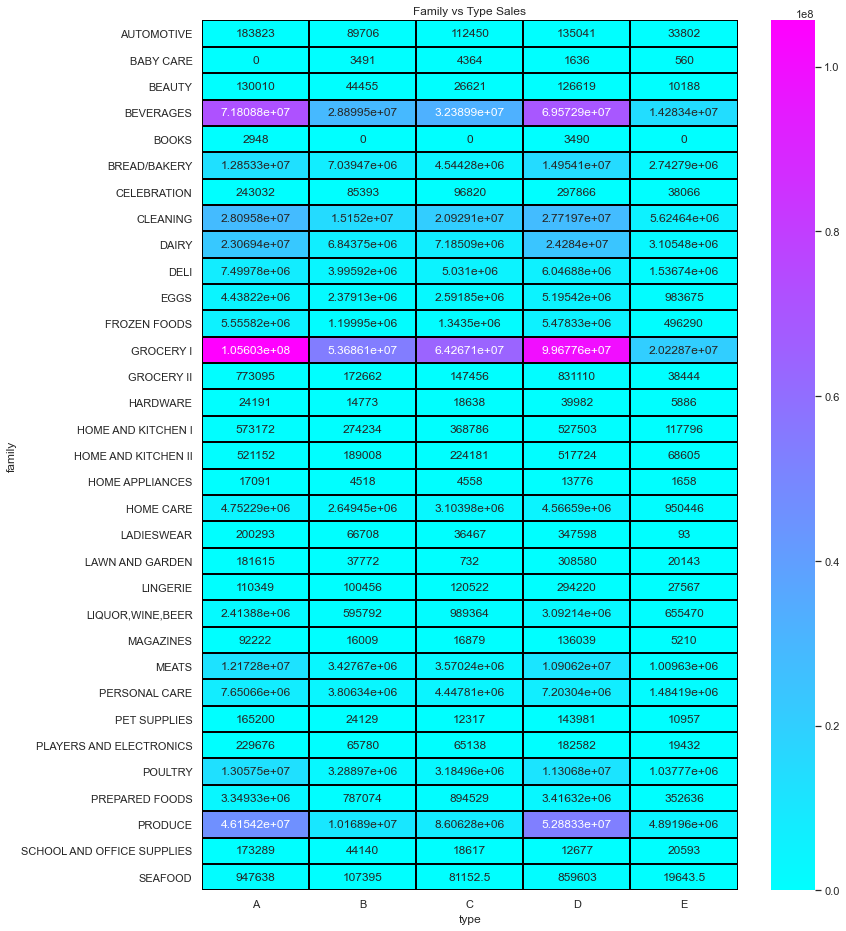

In [66]:
#lets look at the distribution graphically 
plt.figure(figsize=(12,16)) 
plt.title("Family vs Type Sales") 
type_family_heatmap = type_family.pivot_table(values = "sales",index = "family", columns="type",aggfunc=np.sum) 
show = sns.heatmap(type_family_heatmap,cmap="cool", linewidths = 1, linecolor = "Black", annot=True, fmt="g")

In [67]:
#a bit messy...but no obvious relationships between family and type

In [68]:
type_family = pd.DataFrame(train_stores.groupby(["type","family"]).onpromotion.sum())
type_family

onpromotion
type family                                 
A    AUTOMOTIVE                         2758
     BABY CARE                             0
     BEAUTY                             3392
     BEVERAGES                        181303
     BOOKS                                 0
...                                      ...
E    POULTRY                           11030
     PREPARED FOODS                     4404
     PRODUCE                           66839
     SCHOOL AND OFFICE SUPPLIES         1616
     SEAFOOD                            1117

[165 rows x 1 columns]

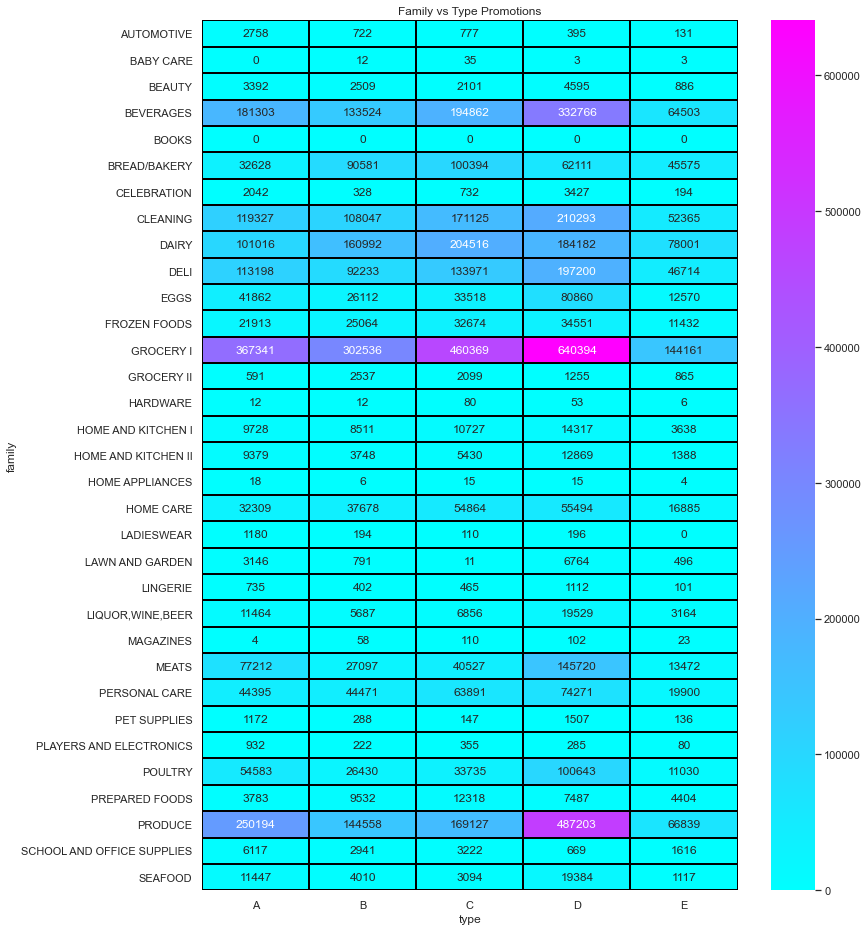

In [69]:
plt.figure(figsize=(12,16)) 
plt.title("Family vs Type Promotions") 
type_family_heatmap = type_family.pivot_table(values = "onpromotion",index = "family", columns="type",aggfunc=np.sum) 
show = sns.heatmap(type_family_heatmap,cmap="cool", linewidths = 1, linecolor = "Black", annot=True, fmt="g")

In [70]:
#since this data is based entirely on sales
#we can only see if items sold were associated with a promotion
#so its hard to judge how intended promotions performed